In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
import cv2
from matplotlib.colors import LogNorm
import pandas as pd
import imutils
from cellpose import utils, io
from scipy.spatial import distance as dist
from imutils import perspective
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio
import skimage.morphology as sk_m
from fil_finder import FilFinder2D

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up a list of segmentation (.npy) files to be run through the process. These files are then sorted by timepoint.

In [2]:
# Load files
files = os.listdir(segments_path)
for fichier in files[:]: 
    if not(fichier.endswith(".npy")):
        files.remove(fichier)

# Sort files by timepoint
files.sort(key = tools.natural_keys)

# Step 2
Load up the data and specifically save the full image and outlines for each cell. 

In [3]:
# Initialize lists
outl_list = []
img_list = []

# Fill lists with img and outline data from each file
for file in files[8:]:
    dat = np.load(segments_path + file, allow_pickle=True).item()
    # Create a list that contains each outline.
    outl = tools.outlines_list(dat['masks'])
    outl_list.append(outl)
    # Create a list that contains each image file. 
    image = dat["img"]
    img_list.append(image)

# Step 3
Create bounding boxes for each outline in each image. 

In [4]:
# Initialize a list of boxes
boxes_list = []

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl in outl_list:
    boxes = tools.get_boxes(outl)
    boxes_list.append(boxes)

# Step 4
Perform cell tracking and save the ID, outline, and centers through time as lists. The reason we are saving the outlines as a list again is because these outlines will be aligned with the ID list, so we will always know which outline belongs to which specific cell over time.

In [5]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_new_list = []
centers_list = []
box_img = img_list.copy()


# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_list, box_img, outl_list):
    # Draw an outline of each box onto the original image
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)
    # update our centroid tracker using the computed set of bounding box rectangles
    objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    centers = []
    # loop over the tracked objects
    for (objectID, info) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (info[0][0] - 10, info[0][1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (info[0][0], info[0][1]), 4, (0, 255, 0), -1)
        # append the object ID and its associated outline and center to the lists. 
        IDs.append(objectID)
        outl_new.append(info[1])
        centers.append(info[0])
    IDs_list.append(IDs)
    outl_new_list.append(outl_new)
    centers_list.append(centers)

# Step 5
Determining the number of pixels which overlap between the different outlines.

In [17]:
overl_list = []
for outl, centers in zip(outl_new_list, centers_list):
    overl_list.append(tools.get_overlap(outl, centers))

## Optimization succesful! 
I have found an optimization in the workbook that basically doubles the run speed for most samples. Will be completely implemented soon. 

# Step 6
Calculate the perimeter size and area of each cell. 

In [7]:
per_list, area_list = tools.peri_area(outl_list)

# Step 7
Create a list of time for the files you are using (assumes the time is in the file names).

In [8]:
time_list = []
for file in files[8:]:
    time_list.append(int(re.findall(r'\d+', file)[0]))

# Step 8
Save the individual masks as png files (It is easier to create skeletons via masks rather than png files.)

In [9]:
tools.save_ind_masks("Individual_cells/", IDs_list, outl_new_list, time_list, img_list)

# Step 9 Skeleton making stuff goes here.

# Step 10
Collect the radial profile along the skeleton for each cell and calculate the pixel intensity along the skeleton (for our purposes, pixel intensity translates to height). 

In [10]:
%%capture # Suppresses a long list of outputs made by radfil, a package this function utilizes. 
radobj_list = tools.radobj_maker("Individual_cells/", IDs_list, time_list)

In [11]:
diam_list, height_list = tools.radobj_extractor(radobj_list)

# Step 11
Calculate the length of the skeleton for each cell.

In [12]:
%%capture # Suppresses a long list of outputs made by radfil, a package this function utilizes. 
length_list = tools.skeleton_length("Individual_cells/", IDs_list, time_list)

# Step 12
Organize the data so that we get a table of metadata for each individual cell ID. 

In [14]:
max_ID = tools.get_max_ID(IDs_list)
for i in range(max_ID):
    df = tools.get_metadata(i, IDs_list, per_list, area_list, overl_list, centers_list,
                      time_list, diam_list, height_list, length_list)
    df.to_csv("metadata/cell_id_" + str(i) + ".csv", index = False)

### Plotting and observing the individual parts of the analyses.

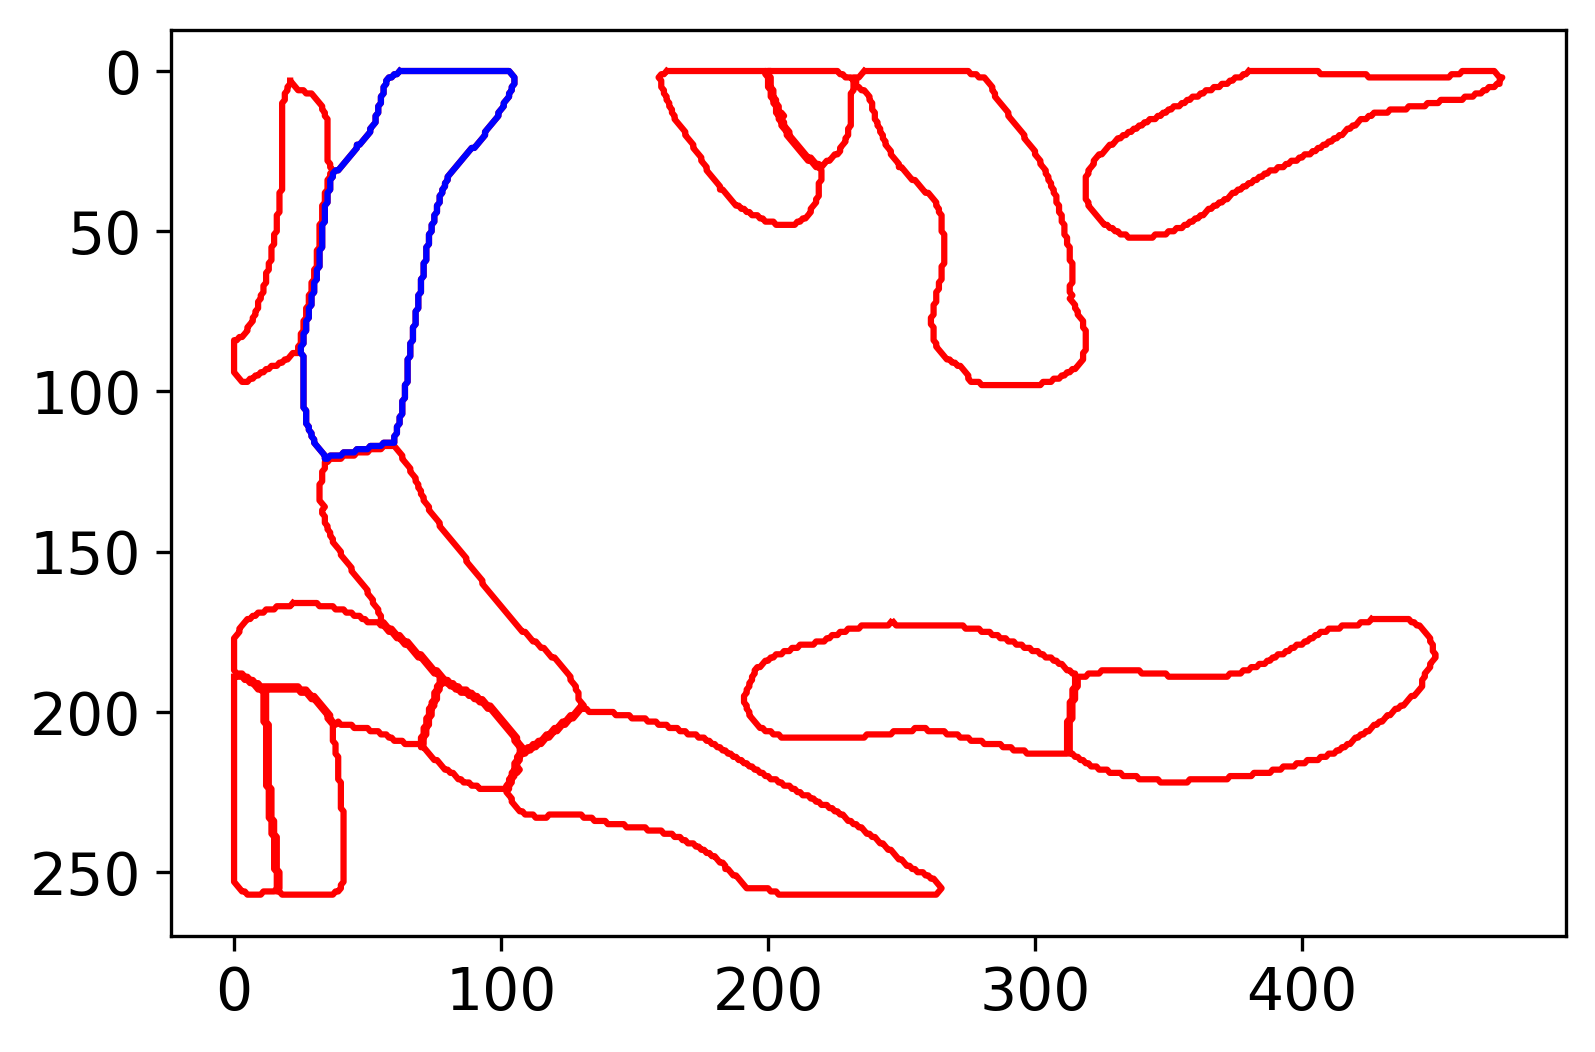

In [15]:
#plot just the outlines. I mostly use this to get a sense for each outline. 
for o in outl_new_list[3]:
    plt.plot(o[:,0], o[:,1], color='r')
plt.plot(outl_new_list[3][5][:,0], outl_new_list[3][5][:,1], color = 'blue')
plt.gca().invert_yaxis()

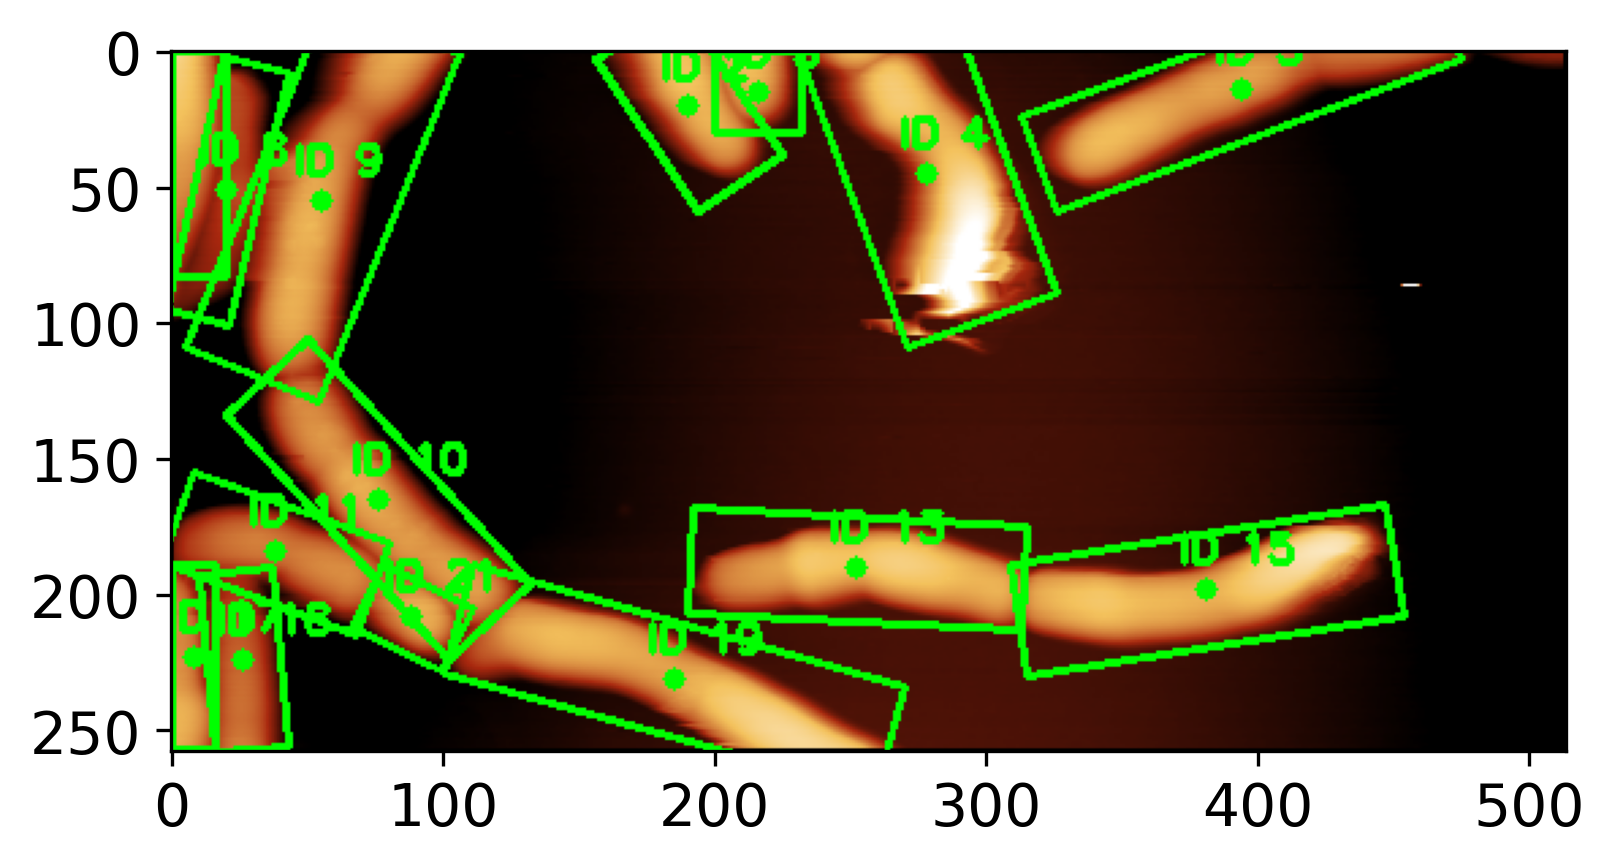

In [16]:
# View the images
plt.imshow(img_list[3])

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. Completed!!! 
- Where was the cell in the overall image. Completed!!!
- What was the time point of this image. Completed!!! 
- Use centroid tracking cell movement on a basic level. Completed!!!
- Find a way to auto filter those weird looking cells. Destroy cells that are greater than 20% above or below the area average? 
- Find a way to align all images within our files folder so that tracking can continue after frameshifting.
- How do I determine if cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears? Would such an event be biased by artifacts that occasionally split one cell into two cells? 

# Note on potential issue:
I have noticed that the AFM data tends to create these "fault lines" where one cell ends up being split in two by some kind of glitch along the scanning line. This may be of some concern given that cellpose tends to think that these split cells are actually seperate cells. 